<h1><center>Projet d'optimisation convexe</center></h1>

<center>Killian Collet, Marwan Khader, Ludwig Trossel</center>

# Import et fonction

In [89]:
# import
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [90]:
# seed
np.random.seed(69)

# définition de quelques fonctions utilisées partout

# obtenir la matrice L à partir de J
def get_L(J=100):
  return (-np.diag(np.ones(J))+np.diag(np.ones(J-1), k=1))[:-1]


#fonction pour préparer les axes afin de tracer les signaux de base et le signal solution
def prepare_axes(ax, title, x_sig, y_sig, x_sol=None):
    ax.set_title(title)
    ax.set_xlabel("time")
    ax.set_ylabel("signal")
    ax.plot(x_sig, marker='o', label="signal original")
    ax.plot(y_sig, label="signal bruité")
    if x_sol is not None:
      ax.plot(x_sol, label="signal solution")
    ax.legend()


#tracer l'erreur
def plot_error(ax, err, title="erreur en fonction du nombre d'itérations"):
  ax.set_title(title)
  ax.set_xlabel("itérations")
  ax.set_ylabel("erreur")
  ax.plot(err, label="erreur")
  ax.legend()


# tracer l'erreur en échelle logarithmique
def plot_error_log(ax, error, title):
  plot_error(ax, error, title)
  ax.set_yscale("log")


# affichage du nombre d'itération pour atteindre la convergence en fonction d'une liste de pas
def plot_n_iter_vs_lr(ax, lr_list, n_iter_list, n_it_max, title="nombre d'itérations en fonction du pas de gradient"):
  ax.set_title(title)
  ax.set_xlabel("pas de gradient")
  ax.set_ylabel("nombre d'itérations")
  ax.plot(lr_list, n_iter_list, marker="o")
  ax.legend(["nombre d'itérations"])

  it_min=n_iter_list[np.argmin(n_iter_list)]
  if it_min < n_it_max:
    print("Le meilleur pas de gradient est : ", lr_list[np.argmin(n_iter_list)])
    print("On atteint la convergence en ", it_min, "itérations")
  else:
    print("Aucun pas de gradient ne permet d'atteindre la convergence en ", n_it_max, "itérations")





# Définition du signal et de sa perturbation

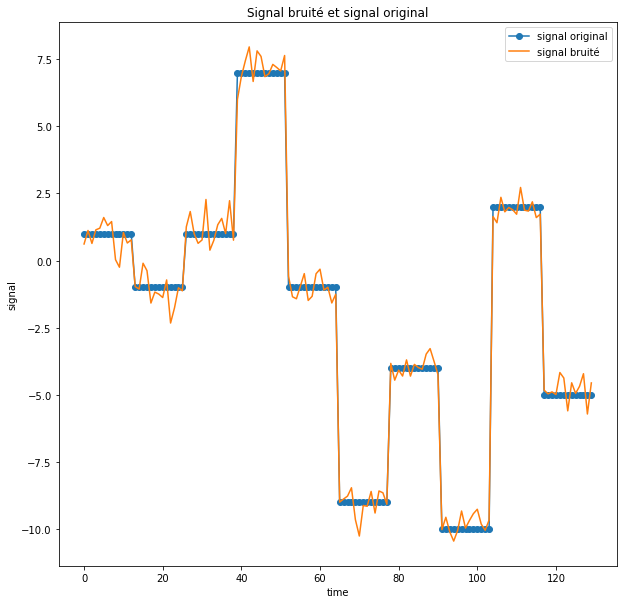

In [91]:
# On définit la fonction qui crée le signal orinal et le signal bruité
def make_signal(J,K,x_min,x_max,sigma):
  x_sig=np.zeros(J)
  K_vec=np.arange(J+1, step=J//K) # indices des sauts
  K_value_for_x=np.random.randint(x_min,x_max,K) # valeurs des constantes du signal

  for i in range(K):
    x_sig[K_vec[i]:K_vec[i+1]]=K_value_for_x[i]   # on remplit le signal avec les constantes

  y_sig=x_sig+np.random.normal(0,sigma,len(x_sig)) # on ajoute le bruit
  return y_sig, x_sig



J=130 # nombre de pas de discrétisation
K=10 # nombre de sauts

# valeurs maximales du signal original
x_min=-10
x_max=10

# variance du bruit
sigma=0.5

#on génère les signaux
y_sig, x_sig=make_signal(J,K,x_min,x_max,sigma)



# on trace les signaux

fig, ax = plt.subplots(figsize=(10,10))
prepare_axes(ax, "Signal bruité et signal original", x_sig, y_sig) # fonction définie à la cellule 2

# Gradient à pas fixe

## Définition du gradient de la fonction objectif

La fonction objectif est définie par :

$$f(x)=\dfrac12||x-y||_2^2+\lambda||Lx||^{1+\eta}_{1+\eta}$$

Le gradient de la fonction objectif est définie par :

$$\nabla f(x)=x-y+(\eta+1)\lambda L^T (\text{sign}(Lx) \otimes |Lx|^\eta)$$

La multiplication notée $\otimes$ est la multiplication terme à terme, de même que la valeur absolue et l'exposant $\eta$.




In [92]:
# On définit le gradient de la fonction objectif
# Elle prend en entrée le signal x, le signal bruité y, le paramètre lambda, la matrice L 
# et le paramètre eta


def f_L1_reg_grad(x,y,lmb, L, eta=0):
  n=1+eta
  terme1=x-y
  #terme2=lmb*L.T@np.sign(L @ x)
  terme2=n*lmb*L.T @ (np.abs((L @ x))**eta*np.sign(L @ x))

  return terme1 + terme2



In [93]:
# descente de gradient à pas fixe

def gradient_descente(x_init, y, lmb, L, lr, eta=0, n_iter=1000, eps=1e-5, verbose=True):
    error=[]
    x=x_init
    for i in range(n_iter):
        x_prev=x
        grad=f_L1_reg_grad(x,y,lmb, L, eta)
        x=x-lr*grad
        error.append(np.linalg.norm(x-x_prev))
        if error[-1]<eps:
            if verbose:
                print("la méthode a convergé en {} itérations".format(i))
            return x, error, i
    if verbose:
        print("la méthode n'a pas convergé en {} itérations".format(n_iter))
    return x, error, n_iter


In [94]:
# paramètres de la descente de gradient
# ils resteront constants pour toute la partie gradient à pas fixe

lmb=3 
J=len(x_sig)
L=get_L(J) #fonction définie à la cellule 2
x_init=np.ones(J)


##  Cas de la norme L1 ( $\eta=0$ )

C'est ce problème qu'on veut résoudre. En effet, on recherche un signal constant par morceaux, autrement dit, on veut que $Lx$ possède autant de zéros que possible, sauf au niveau des sauts du signal original. Minimiser la norme L1 a tendance à générer ce genre de solutions (propriété de sparsité)

La fonction objectif n'est pas différentiable. Cela rend problématique l'application de l'algorithme du gradient à pas, comme nous allons le voir ci dessous.

Notons que le gradient, quand il existe, se réduit à :

$$\nabla f(x)=x-y+\lambda L^T \text{sign}(Lx)$$

Aux points où f n'est pas différentiable, i.e pour un signal x constant, on renvoie x-y .

La fonction objectif est strictement convexe et coervice, donc le problème de minimisation admet une solution unique.
On constate que même si la méthode ne converge pas, les solutions renvoyées  sont relativement acceptables.

### Mise en oeuvre

la méthode n'a pas convergé en 5000 itérations


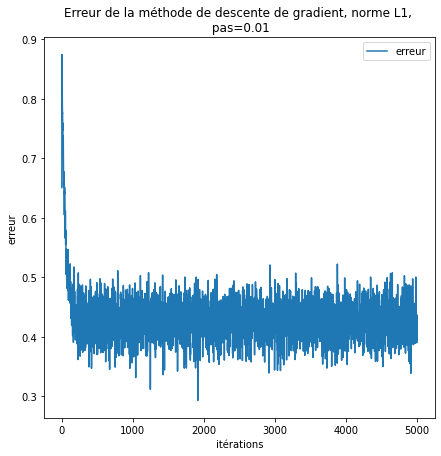

In [95]:
eta=0 # cas de la norme L1
lr=0.01 # voir partie suivante pour détails

# descente de gradient à pas fixe
x_sol, err, _ = gradient_descente(x_init, y_sig, lmb, L, lr, eta, n_iter=5000, eps=1e-5)

# tracer l'erreur
fig, ax = plt.subplots(figsize=(7,7))
title="Erreur de la méthode de descente de gradient, norme L1, \n pas={}".format(lr)
plot_error(ax, err, title)

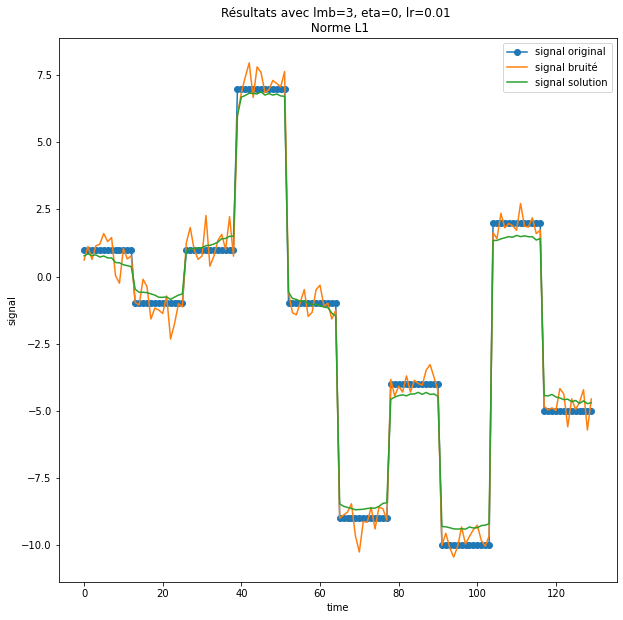

In [96]:
# on trace les signaux

title="Résultats avec lmb={}, eta={}, lr={} \n Norme L1".format(lmb, eta, lr)
figure=plt.figure(figsize=(10,10))
ax=figure.add_subplot(111)

prepare_axes(ax,title, x_sig, y_sig, x_sol)

    

### A propos du pas

Quelque soit le pas, la méthode ne converge pas dans ce cas. Ceci dit, plus on le choisit petit, plus on oscille proche de la solution, mais plus cela prend du temps.

On aurait probablement pu améliorer les résultats en utilisant un pas adaptatif, mais nous verrons une méthode plus efficace dans la suite pour résoudre ce problème.


## Cas de la norme L2 ( $\eta=1$ )
C'est un cas où la méthode du gradient à pas fixe fonctionne bien : la fonction objectif est telle que son gradient est L-Lipschitzien, donc la méthode du gradient à pas fixe converge si le pas est suffisamment petit. (voir partie suivante pour plus de détails)


La convergence est rapide, mais la solution n'est pas très satisafaisante. En effet, le signal solution obtenu n'est absolument pas constant par morceaux, même avec un $\lambda$ très grand.

### Mise en oeuvre

la méthode a convergé en 158 itérations
L'ordre de convergence est w^(-k), avec w=0.9211378532683441, et k le nombre d'itérations


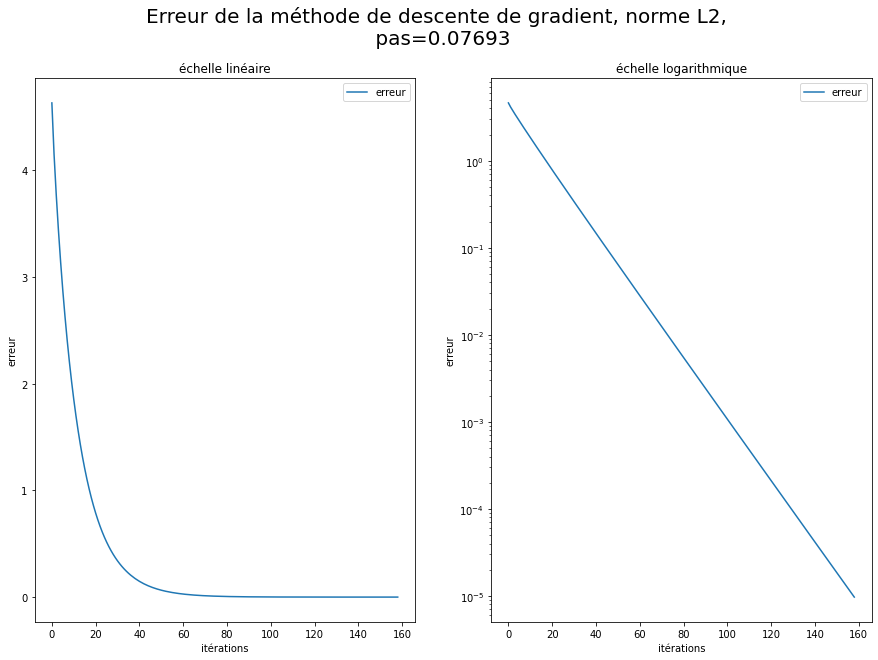

In [97]:
eta=1 # cas de la norme L2

# On calcule L et alpha : ce sont les valeurs propres max de H
H=np.diag(np.ones(J))+lmb*L.T@L # Hessienne de la fonction objectif
L_lip=np.linalg.eigvalsh(H).max() # constante de Lipschitz

# On calcule le pas de gradient
lr=1/L_lip


x_init=np.zeros(J)

x_sol_eta_1, err_eta1, _ = gradient_descente(x_init, y_sig, lmb, L, lr=lr, eta=1, n_iter=10000, eps=1e-5)

# on trace l'erreur, échelle classique et logarithmique sur la même figure

#calcul de l'ordre de convergence
log_w=np.polyfit(np.arange(len(err_eta1)), np.log(err_eta1), 1)[0]
w=np.exp(log_w)
print("L'ordre de convergence est w^(-k), avec w={}, et k le nombre d'itérations".format(w))



fig, ax= plt.subplots(figsize=(15,10), nrows=1, ncols=2)

# titre
title="Erreur de la méthode de descente de gradient, norme L2, \n pas={}".format(round(lr,5))
fig.suptitle(title, fontsize=20)
plot_error(ax[0], err_eta1, "échelle linéaire")
plot_error_log(ax[1], err_eta1, "échelle logarithmique")


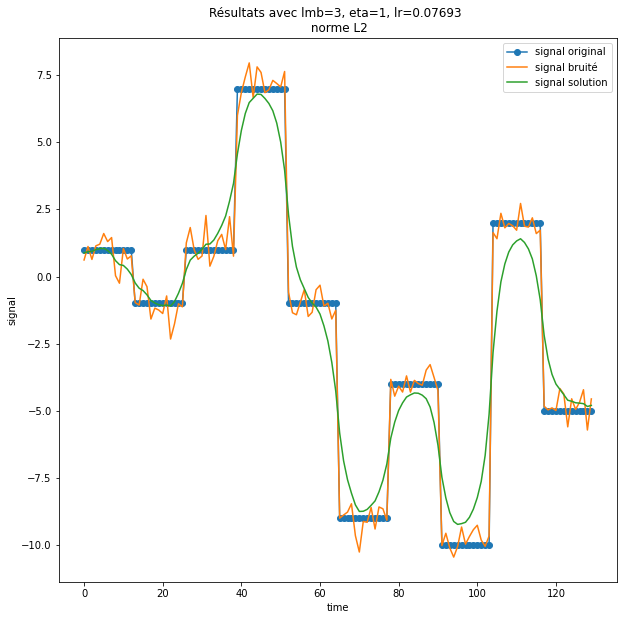

In [98]:
# affichage des résultats

title="Résultats avec lmb={}, eta={}, lr={} \n norme L2".format(lmb, eta, round(lr,5))
figure=plt.figure(figsize=(10,10))
ax=figure.add_subplot(111)

prepare_axes(ax,title, x_sig, y_sig, x_sol_eta_1)

### A propos du pas

La fonction objectif est telle que son gradient est L-Lipschitzien.
La théorie nous assure qu'un pas inferieur à $2/L$ suffit pour assurer la convergence de l'algorithme.

Pour déterminer $L$, on récupère la valeur propre maximale de la matrice de Hessienne de la fonction objectif. 

Pour rappel, le gradient de la fonction objectif, dans ce cas, est : 

$$\nabla f(x)=x-y+2\lambda L^T Lx= (\text{Id} + 2\lambda L^T L)x -y$$

et donc la matrice de Hessienne est :

$$H(x)=\text{Id} + 2\lambda L^T L$$

On a donc choisi un pas de $1/L$, en récupérerant la valeur propre maximale de la matrice de Hessienne avec la fonction numpy.linalg.eigvalsh.

Dans la cellule suivante, on illustre la convergence de l'algorithme en fonction du pas choisi et on constate que le pas choisi est en fait (pas loin d'être) le meilleur.



L=12.998248084481162 et 1/L=0.07693344468428154

Recherche du meilleur pas de gradient expérimentalement :
Le meilleur pas de gradient est :  0.07778
On atteint la convergence en  172 itérations


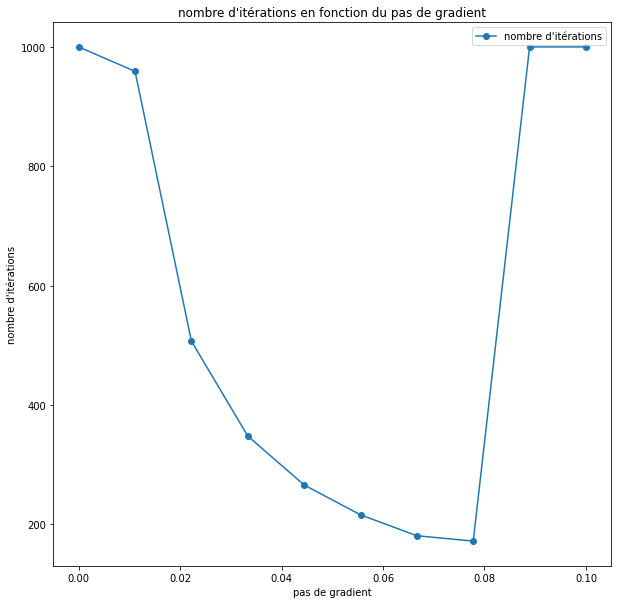

In [99]:
# recherche du meilleur pas
# pour différentes valeurs de lr, on calcule recupérer le nombre d'itérations nécessaires pour atteindre une précision donnée

print("L={} et 1/L={}".format(L_lip,1/L_lip))


n_it_max=1000
lr_list=lr_list=np.linspace(1e-5,1e-1,10)
n_iter_list=[]
for lr in lr_list:
    x_sol, err, n_iter=gradient_descente(x_init, y_sig, lmb, L, lr=lr, eta=1, n_iter=n_it_max, eps=1e-5, verbose=False)
    n_iter_list.append(n_iter)

print("\nRecherche du meilleur pas de gradient expérimentalement :")

# on trace le nombre d'itérations en fonction du pas de gradient
fig, ax = plt.subplots(figsize=(10,10))
plot_n_iter_vs_lr(ax, lr_list, n_iter_list, n_it_max=n_it_max)

## Cas de la norme 1<p<2 > ($0<\eta<1)$

Pour la norme 1, la méthode ne converge pas. Pour la norme 2, la méthode converge très vite, mais la solution n'est pas très satisfaisante. On va donc essayer de trouver un compromis entre les deux. Aussi on va essayer de résoudre le problème avec la norme 1<p<2 ( c'est à dire $\eta$ entre 0 et 1 ).

Dans ce cas, la fonction objectif est toujours strictement convexe et coervice, donc le problème de minimisation admet une solution unique. Par rapport au cas de la norme 1, elle est de plus différentiable. 

Par contre, est-elle lipschitzienne ? Si elle ne l'est pas, nous ne somme pas assuré que la méthode du gradient à pas fixe converge. Dans les résultats suivants, on annonce "la méthode a convergé", mais cela signifie que l'erreur est inferieure à un seuil donné, mais cela ne signifie pas que la méthode va réellement converger. 


### Mise en oeuvre

eta=0.3
la méthode n'a pas convergé en 10000 itérations
eta=0.2
la méthode n'a pas convergé en 10000 itérations
eta=0.8
pseudo convergence, les erreurs sont simplements inférieures à eps=0.001
la méthode a convergé en 3852 itérations


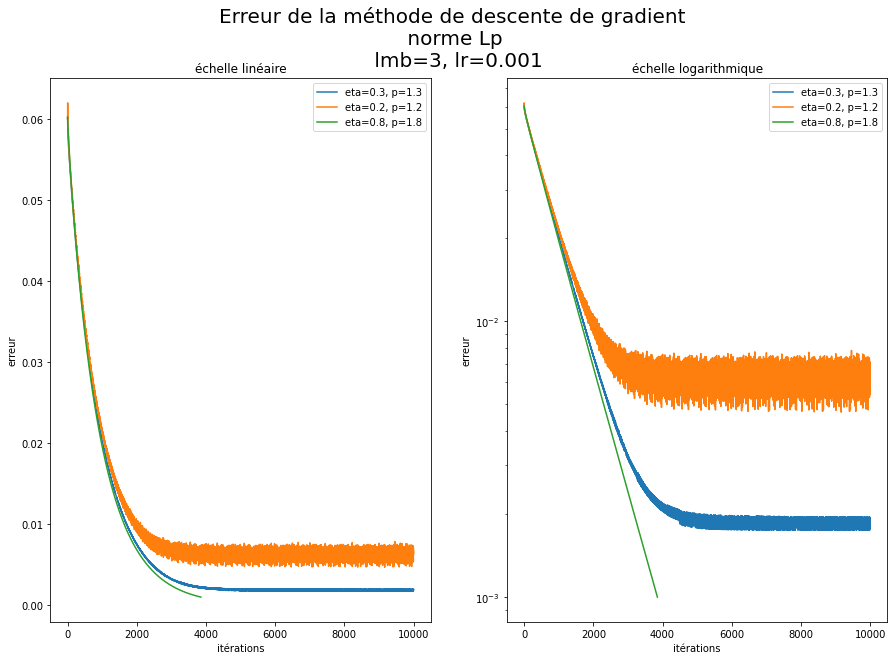

In [100]:
lr=0.001
eps=1e-3

eta=0.3
print("eta={}".format(eta))
x_sol_eta_03, err_eta_03, _ = gradient_descente(x_init, y_sig, lmb, L, lr=lr, eta=eta, n_iter=10000, eps=eps)

eta=0.2
print("eta={}".format(eta))
x_sol_eta_02, err_eta_02, _ = gradient_descente(x_init, y_sig, lmb, L, lr=lr, eta=eta, n_iter=10000, eps=eps)

eta=0.8
print("eta={}".format(eta))
print("pseudo convergence, les erreurs sont simplements inférieures à eps={}".format(eps))
x_sol_eta_08, err_eta_08, _ = gradient_descente(x_init, y_sig, lmb, L, lr=lr, eta=eta, n_iter=10000, eps=eps)


# On trace les 3 erreurs sur 2 graphes : l'un en échelle linéaire, l'autre en échelle logarithmique

fig, ax = plt.subplots(figsize=(15,10), nrows=1, ncols=2)
title="Erreur de la méthode de descente de gradient \n norme Lp \n lmb={}, lr={}".format(lmb, round(lr,4))
fig.suptitle(title, fontsize=20)
plot_error(ax[0], err_eta_03, "échelle linéaire")
plot_error(ax[0], err_eta_02, "échelle linéaire")
plot_error(ax[0], err_eta_08, "échelle linéaire")
# label
ax[0].legend(["eta=0.3, p=1.3", "eta=0.2, p=1.2", "eta=0.8, p=1.8"])
plot_error_log(ax[1], err_eta_03, "échelle logarithmique")
plot_error_log(ax[1], err_eta_02, "échelle logarithmique")

plot_error_log(ax[1], err_eta_08, "échelle logarithmique")
# label
_=ax[1].legend(["eta=0.3, p=1.3", "eta=0.2, p=1.2", "eta=0.8, p=1.8"])





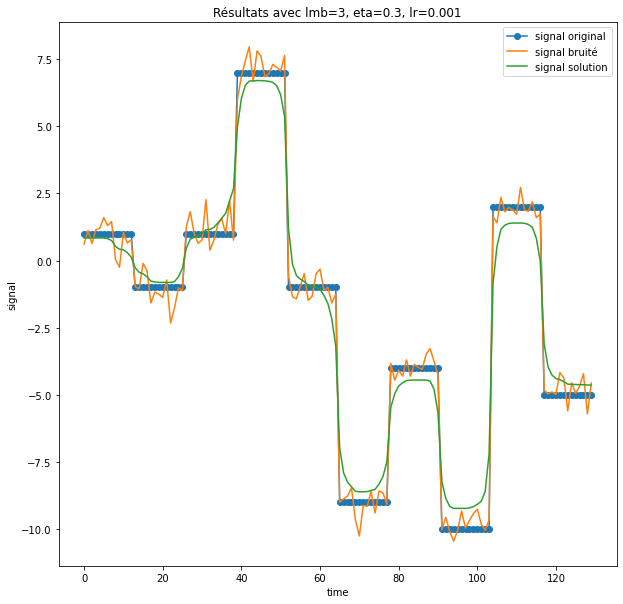

In [101]:
# affichage des résultats pour eta=0.3
eta=0.3
title="Résultats avec lmb={}, eta={}, lr={}".format(lmb, eta, lr)
figure=plt.figure(figsize=(10,10))
ax=figure.add_subplot(111)

prepare_axes(ax,title, x_sig, y_sig, x_sol_eta_03)

### A propos du pas

Le gradient n'est pas L-Lipschitzien (affirmation péremptoire basée sur l'intuition). Si tel est le cas, la recherche du pas de convergence n'est pas claire, et d'ailleurs, nous ne sommes même pas assurés que la méthode converge. Et si par hasard elle converge, nous ne sommes pas en mesure d'estimer le taux de convergence.

Le pas a donc été choisi, de sorte à illustrer une pseudo convergence dans certain cas, et la non convergence nette dans d'autres.



# Problème dual et résolution

La résolution du problème dual permet de résoudre le problème inital (norme L1) de manière extrêmement satisfaisante. Voyons comment on passe du problème inital au problème dual :

Le problème inital s'écrit : 

$$ \mathcal{P} :   \min_{x} f(x)+g(Lx)$$ 

où 
$$ f(x)=\dfrac12||x-y||_2^2 \text{ et } g(z)=\lambda||z||^{1}_{1} \text{ avec } x,y \in \mathbb{R}^J, z \in \mathbb{R}^{J-1} $$


Comme g est convexe et semi continue inferieurement, on a $g=g^{**}$, et le problème $\mathcal{P}$ peut se récrire :

\begin{align*}
\mathcal{P} :   \min_{x} f(x)+g^{**}(Lx)  & = \min_x f(x)+\sup_{u} \big(\langle u, Lx \rangle- g^*(u) \big)  \\
                                          & = \min_x \sup_{u} f(x)+ \langle L^Tu, x \rangle- g^*(u)     
\end{align*}

Le problème dual consiste à échanger l'ordre du min et du sup. On applique quelques transformations pour obtenir la forme finale qu'on va résoudre : 

\begin{align*}
\mathcal{D} : \sup_{u} \inf_{x} f(x)+ \langle L^Tu, x \rangle- g^*(u) & = \sup_{u}  - \sup_{x} \big( \langle -L^Tu, x \rangle - f(x) \big) - g^*(u) \\
                                                            & = \sup_{u} -f^*(-L^Tu)-g^*(u)          & & \text{(1)} 
\end{align*}

Comme g et f sont convexes et semi-continue inférieurement, l'inf du problème $\mathcal{P}$ est égal au sup du problème $\mathcal{D}$ (dualité forte).

En notant $x_\lambda$ la solution du problème $\mathcal{P}$ ( que l'on sait unique) et $u_\lambda$ une solution du problème $\mathcal{D}$ , on a donc :

$$ f(x_\lambda)+g(Lx_\lambda)+f^*(-L^Tu_\lambda)+g^*(u_\lambda)=0$$

Mais $g(Lx_\lambda)+g^*(u_\lambda)\geqslant\langle x_\lambda,L^Tu_\lambda \rangle$ donc, 
$0 \geqslant f(x_\lambda)+f^*(-L^Tu_\lambda) + \langle x_\lambda,L^Tu_\lambda \rangle$

et comme $f(x_\lambda)+f^*(-L^Tu_\lambda)\geqslant \langle x_\lambda,-L^Tu_\lambda \rangle$,
on en déduit que $f(x_\lambda)+f^*(-L^Tu_\lambda) + \langle x_\lambda,L^Tu_\lambda \rangle = 0$

On a donc $f(x_\lambda)+f^*(-L^Tu_\lambda) = \langle x_\lambda, - L^Tu_\lambda \rangle $, autrement dit, $x_\lambda \in \partial f^*(-L^Tu_\lambda)$ (valable car $f=f^{**}$) et donc, si $f^*$ est différentiable, 

$$x_ \lambda = \nabla f^*(-L^Tu_\lambda) \hspace{1cm} (2)$$

Il nous reste à donner les expressions de $f^*$ et $g^*$ pour donner une forme explicite au problème $\mathcal{D}$ ( grâce à (1) ) et montrer comment on retrouve $x_\lambda$ à partir de $u_\lambda$ ( grâce à (2) ).

Il s'avère que :
$$f^*(v) = \dfrac12||v||^2 + \langle v, y \rangle = \dfrac12 || v+y ||^2 - \dfrac12 ||y||^2$$ 
et 
$$g^*(u) = \mathcal{I}_{B_{\infty}(0,\lambda)}(u) \hspace{1cm} \text{( 0 si $||u||_\infty\leqslant\lambda$, $+\infty$ sinon )}$$
 Donc $\mathcal{D}$, écrit sous la forme (1), devient : 

\begin{align*}
\mathcal{D} : \sup_{u} - \dfrac12||y-L^Tu||^2 - \dfrac12 ||y||^2 - \mathcal{I}_{B_{\infty}(0,\lambda)}(u) 
& = - \inf_{u}  \dfrac12||y-L^Tu||^2 + \mathcal{I}_{B_{\infty}(0,\lambda)}(u) \\
& = - \inf_{||u||_{\infty}\leqslant\lambda} \dfrac12||y-L^Tu||^2
 \end{align*}

Une solution $u_\lambda$ de ce problème est également solution du problème tel qu'il est posé dans l'énoncé, à savoir :

$$ \mathcal{D} :\inf_{||u||_{\infty}\leqslant\lambda} \dfrac12||y-L^Tu||^2$$

Enfin, le gradient de $f^*$ vaut $\nabla f^*(v) = v+y$ et on a donc, en se rappelant de la relation (2) : 
$$x_\lambda = \nabla f^*(-L^Tu_\lambda) = -L^Tu_\lambda+y$$


## Définition de la fonction objectif, de son gradient et de la projection



In [102]:
# fonction objectif duale

def f_dual(u, y, lmb, L):
    return 0.5*np.linalg.norm(L.T@u-y)**2

# gradient de la fonction objectif duale

def f_dual_grad(u, y, lmb, L):
    return L@(L.T@u-y)

# projection sur le carré des vecteurs de norme infinie inférieure à lmb

def proj(u, lmb):
    return np.sign(u)*np.minimum(np.abs(u), lmb)


## Résolution du problème dual

Le problème admet une solution : nous minimisons une fonction continue sur un compact. Son gradient est Lipschitzien, et donc la méthode va converger si le pas est assez petit (voir partie suivante pour le choix du pas)

In [103]:
# descente de gradient projeté

def gradient_descente_projetee(u_init, y, lmb, L, lr, n_iter=1000, eps=1e-5, verbose=True):
    error=[]
    u=u_init
    for i in range(n_iter):
        u_prev=u
        grad=f_dual_grad(u,y,lmb, L)
        u=proj(u-lr*grad, lmb)
        error.append(np.linalg.norm(u-u_prev))
        if error[-1]<eps:
            if verbose:
                print("la méthode a convergé en {} itérations".format(i))
            return u, error, i
    if verbose:
        print("la méthode n'a pas convergé en {} itérations".format(n_iter))
    return u, error, n_iter


la méthode a convergé en 1091 itérations


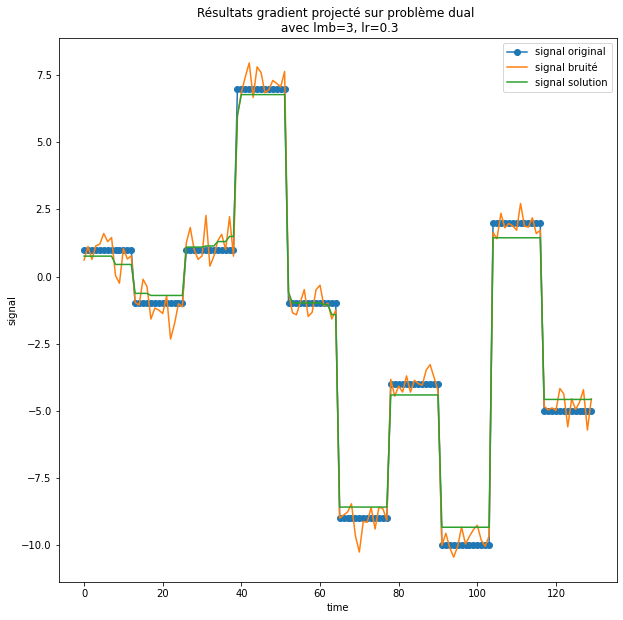

In [104]:
# calcul du pas, voire partie suivante

lmax=np.max(np.linalg.eig(L@L.T)[0]) #constante L
lr=1/lmax #1/L

# calcul de la solution duale
u_init=np.zeros(J-1)
u_sol_proj, err_proj, _ = gradient_descente_projetee(u_init, y_sig, lmb, L, lr=lr, n_iter=10000, eps=1e-8)

# retrouver la solution du problème primal
x_sol_proj=y_sig-L.T@u_sol_proj




title="Résultats gradient projecté sur problème dual \n avec lmb={}, lr={}".format(lmb, eta, round(lr,4))
figure=plt.figure(figsize=(10,10))
ax=figure.add_subplot(111)

prepare_axes(ax,title, x_sig, y_sig, x_sol_proj)

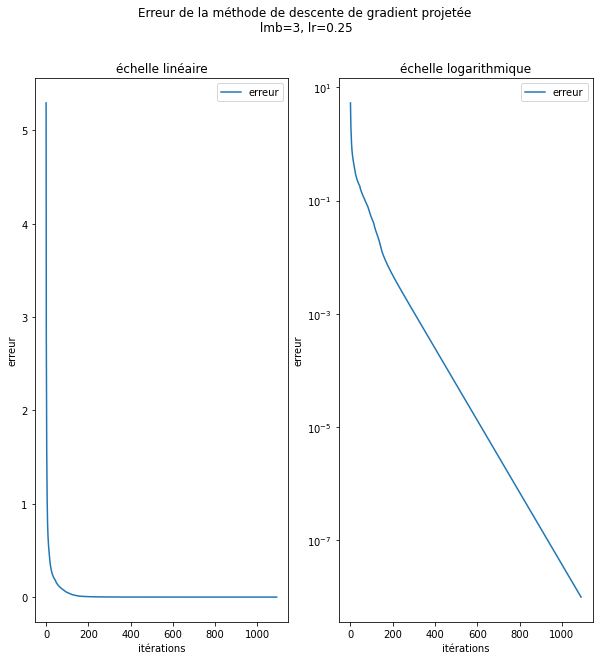

In [105]:
# on trace l'erreur : échelle linéaire et logarithmique
fig, ax = plt.subplots(figsize=(10,10), ncols=2, nrows=1)

plt.suptitle("Erreur de la méthode de descente de gradient projetée\n lmb={}, lr={}".format(lmb, round(lr,4)))
plot_error(ax[0], err_proj, "échelle linéaire")
plot_error_log(ax[1], err_proj, "échelle logarithmique")

## A propos du pas

La fonction objectif est telle que son gradient est L-Lipschitzien. En effet, on a :

Le gradient de la fonction objectif est donné par :

$$\nabla f(x) = L^T(Lx-y)$$

et donc la Hessienne est donnée par :

$$H(x) = L^TL$$

Aussi, on en déduit que la fonction objectif est telle que son gradient est Lipschitzien, avec L la valeur propre maximale de la matrice $L^TL$.

Un pas inférieur à 1/L suffit pour que la méthode converge. Expérimentalement, on trouve dans ce cas un pas optimal de l'ordre de 2/L



L=3.9994160281603834 et 1/L=0.2500365035692402

Recherche du meilleur pas de gradient expérimentalement :
Le meilleur pas de gradient est :  0.46415888336127775
On atteint la convergence en  354 itérations


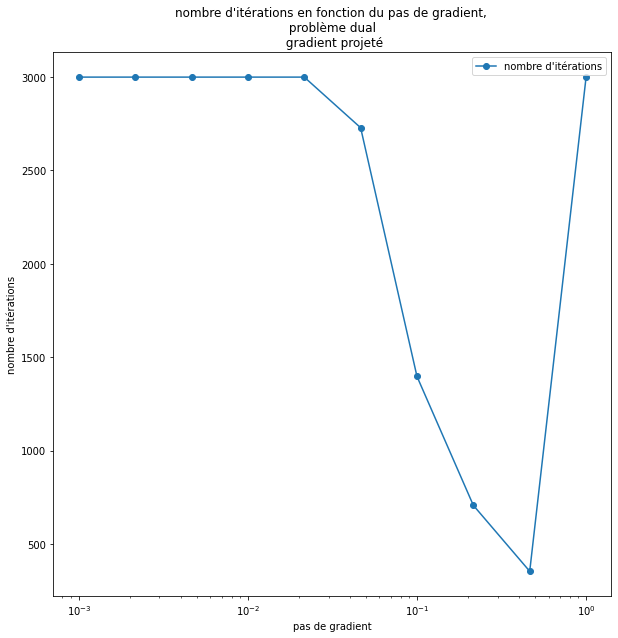

In [106]:
# recherche du meilleur pas


# print L, 1/L
print("L={} et 1/L={}".format(lmax, 1/lmax))


it_max=3000

lr_list=np.logspace(-3,0,10)
n_iter_list=[]
for lr in lr_list:
    u_sol_proj, err_proj, n_iter=gradient_descente_projetee(u_init, y_sig, lmb, L, lr=lr, n_iter=it_max, eps=1e-5, verbose=False)
    n_iter_list.append(n_iter)

# on trace le nombre d'itérations en fonction du pas de gradient

print("\nRecherche du meilleur pas de gradient expérimentalement :")
fig, ax = plt.subplots(figsize=(10,10))
title="nombre d'itérations en fonction du pas de gradient, \n problème dual \n gradient projeté"
plot_n_iter_vs_lr(ax, lr_list, n_iter_list, n_it_max=it_max, title=title)
# log scale
ax.set_xscale('log')




## Variation des paramètres

On fait varier $\lambda$ et $\sigma$ pour voir l'effet sur la solution.

On constate que à $\sigma$ fixé :

- plus $\lambda$ est grand, moins la solution a de sauts, mais en contrepartie, elle s'éloigne du signal original. Avec un $\lambda$ trop grand, la solution va tendre vers un signal quasi-constant, très éloigné donc du signal original.
- plus $\lambda$ est petit, moins la solution a de sauts et se rapproche du signal bruité : nous ne sommes alors pas en mesure d'approcher correctement les valeurs constantes du signal original.

On voit donc que le choix de $\lambda$ est important pour obtenir une solution satisfaisante.

Dans la suite, on fait varier $\sigma$ et $\lambda$, et on mesure la qualité de la solution obtenue en calculant la norme de la différence entre la solution et le signal original. En pratique, nous n'avons pas accès au signal original.  

On constate que plus $\sigma$ est grand, plus on doit choisir un $\lambda$ grand. Rappelons néanmoins que nous n'avons à priori aucune information sur $\sigma$.

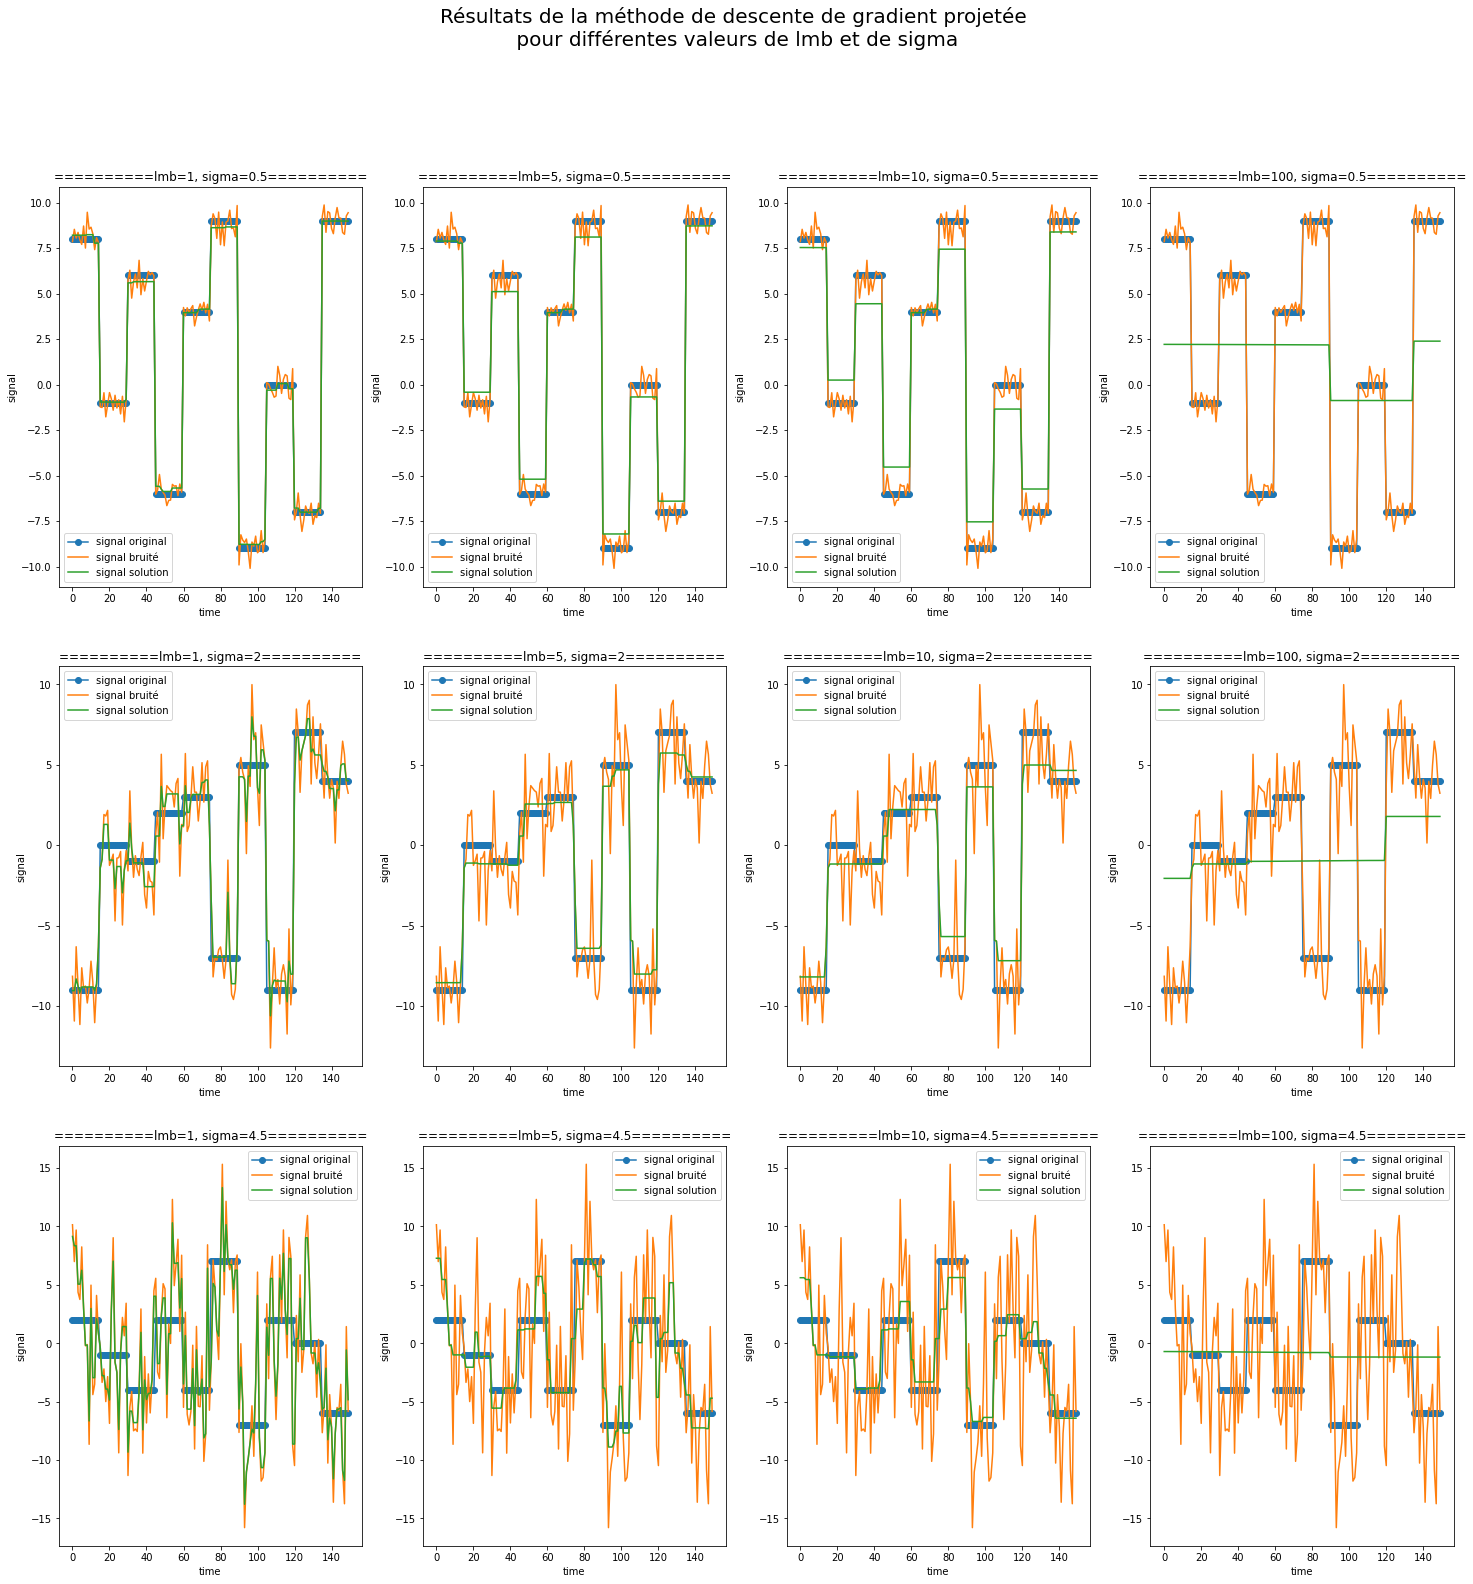

In [107]:
#Illustration
# Variation de sigma et de lmb

sig_list=[0.5, 2, 4.5]
lmb_list=[1, 5, 10, 100]


# paramètres du signal original
J=150
K=10
x_min=-10
x_max=10

# grosso-modo le meilleur pas
lr=0.4

# préparation figure
fig, ax = plt.subplots(figsize=(25,25), nrows=len(sig_list), ncols=len(lmb_list))
fig.subplots_adjust(hspace=0.2, wspace=0.2)
fig.suptitle("Résultats de la méthode de descente de gradient projetée\n pour différentes valeurs de lmb et de sigma", fontsize=20)




# on génère les signaux bruités, puis on calcule les solutions

for i,sig in enumerate(sig_list):
    y_sig, x_sig = make_signal(J,K,x_min,x_max,sig)
    for j,lmb in enumerate(lmb_list):      
        L=get_L(len(x_sig))
        u_init=np.zeros(J-1)
        
        u_sol_proj, err_proj, it = gradient_descente_projetee(u_init, y_sig, lmb, L, lr=lr, n_iter=10000, eps=1e-3, verbose=False)
        x_sol_proj=y_sig-L.T@u_sol_proj

        title= "="*10+"lmb={}, sigma={}".format(lmb, sig)+"="*10
        prepare_axes(ax[i,j],title, x_sig, y_sig, x_sol_proj)



In [108]:
## FAITES TOURNER CETTE CELLULE A VOS RISQUES ET PERILS
## C'EST LONG !!
## L'alternative consiste à importer directement le dataframe df à la cellule suivante si vous le possédez.


genere_df = False

# Création d'un dataframe pour stocker quelques statistiques sur chaque simulation


# On applique la méthode avec plus de valeurs de sigma et de lmb
# On récupère quelques informations sur les résultats obtenus dans un dataframe

# liste de 50 sigma de 0.1 à 5
sig_list=np.linspace(0.1,5,50)

#liste de 50 lmb de 0.1 à 30
lmb_list=np.linspace(0.1,20,50)

# Création d'un dataframe pour stocker quelques résultats
# colonne 1 : sigma
# colonne 2 : lambda
# colonne 3 : nombre d'itérations
# colonne 4 : différence de la norme L2 entre x_sol et x_sig 
# colonne 5 : différence de la norme L2 entre L @ x_sol et L @ x_sig <= si proche de 0, les sauts coincident
# colonne 6 : moyenne des colonnes 4 et 5

# En fait, seule la colonne 4 est utilisée pour la suite

if genere_df:

    df=pd.DataFrame(columns=["sigma", "lambda", "nb it", "|x_sol-x_sig|", "|L @ x_sol-L @ x_sig|", "moy"])


    # on génère les signaux bruités, puis on calcule les solutions

    for i,sig in enumerate(sig_list):
        y_sig, x_sig = make_signal(J,K,x_min,x_max,sig)
        for j,lmb in enumerate(lmb_list):      
            L=get_L(len(x_sig))
            u_init=np.zeros(J-1)

            u_sol_proj, err_proj, it = gradient_descente_projetee(u_init, y_sig, lmb, L, lr=lr, n_iter=10000, eps=1e-3, verbose=False)
            x_sol_proj=y_sig-L.T@u_sol_proj
            crit_1=np.linalg.norm(x_sol_proj-x_sig)
            crit_2=np.linalg.norm(L@x_sol_proj-L@x_sig)
            moy=(crit_1+crit_2)/2
            df=df.append({"sigma":sig, "lambda":lmb,  "nb it":it, "|x_sol-x_sig|":crit_1,
                        "|L @ x_sol-L @ x_sig|":crit_2, "moy": moy}, ignore_index=True)




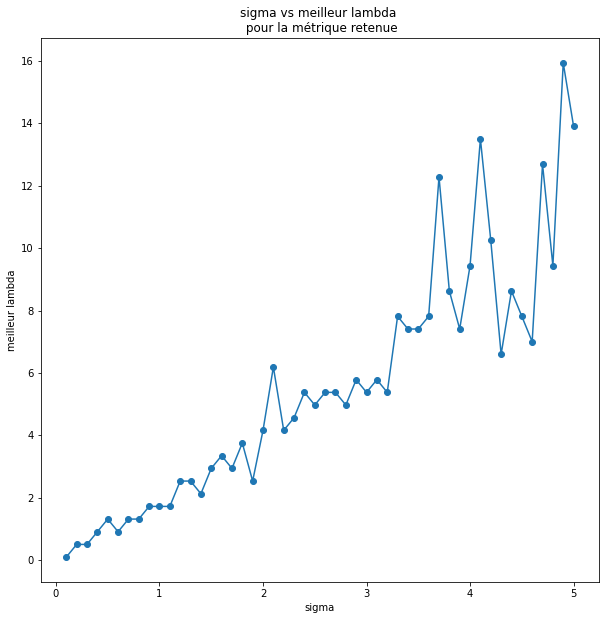

In [109]:
# on exporte le dataframe csv
#df.to_csv("df.csv", index=False)

#si df n'existe pas, on essaie de l'importer, et si on ne peut pas, on le fait savoir
try:
    df
except NameError:
    print("df n'existe pas, on va essayer de l'importer depuis df.csv")
    try:
        df=pd.read_csv("df.csv")
    except FileNotFoundError:
        print("df.csv n'a pas été trouvé, assurez-vous de le posséder et qu'il soit dans le même dossier que ce notebook")

# si df existe, alors on peut poursuivre

# pour un sigma donné, on récupère la ligne correspondant au lambda qui 
# minimise la distance entre x_sol et x_sig

df_min=df.groupby("sigma")
df_min=df_min.apply(lambda x: x.loc[x["|x_sol-x_sig|"].idxmin()])
df_min=df_min.reset_index(drop=True)


# plot sigma vs lambda

plt.figure(figsize=(10,10))
plt.plot(df_min["sigma"], df_min["lambda"], "o-")
plt.xlabel("sigma")
plt.ylabel("meilleur lambda")
plt.title("sigma vs meilleur lambda \n pour la métrique retenue")
plt.show()




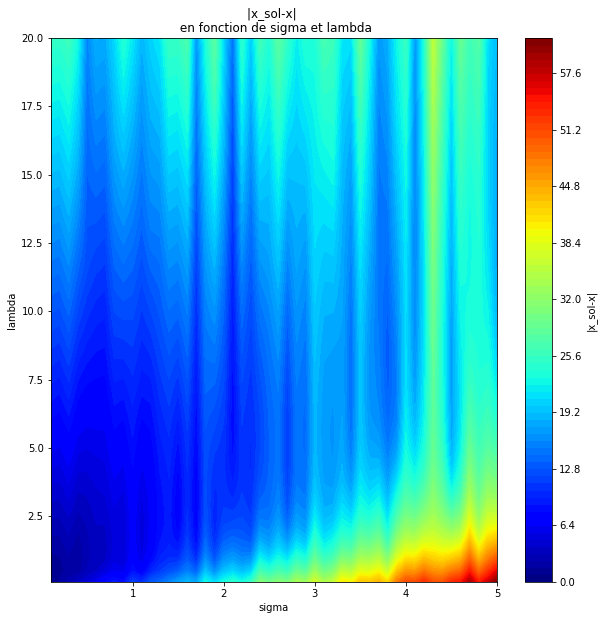

In [110]:
#contour plot df moy vs sigma et lambda

n_sig=df["sigma"].nunique()
n_lmb=df["lambda"].nunique()

try:
    X=df["sigma"].values.reshape(n_sig, n_lmb)
    Y=df["lambda"].values.reshape(n_sig, n_lmb)
    Z=df["|x_sol-x_sig|"].values.reshape(n_sig, n_lmb)


    plt.figure(figsize=(10,10))
    plt.contourf(X, Y, Z, 100, cmap="jet")
    plt.xlabel("sigma")
    plt.ylabel("lambda")
    plt.title("|x_sol-x_sig| \n en fonction de sigma et lambda")
    # label the colorbar vertically
    plt.colorbar(label="|x_sol-x|", orientation="vertical")
    plt.show()
# si df n'existe pas, on explique le problème
except NameError:
    print("df n'existe pas, assurez-vous de l'avoir définie dans les cellules précédentes")
    raise NameError
